In [18]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8455.51it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8043.32it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [20]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512
hidden_dims = [512, 512, 512, 512, 512]
autoencoder = SimpleAutoencoder(512,512)
##### eval
REF_EPOCH = 100
TAR_EPOCH = 100
# init_data = tar_provider.train_representation(TAR_EPOCH)

data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH))
dataloader = data_loader.get_data_loader()


In [3]:
# from AlignVisAutoEncoder.data import PairedDataset
# paired_dataset = PairedDataset(torch.Tensor(ref_train_data), torch.Tensor(tar_train_data))
# split_ratio = 0.8 # 80% of the data will be used for training
# num_samples = len(paired_dataset)
# print(num_samples)
# indices = list(range(num_samples))
# split = int(np.floor(split_ratio * num_samples))

# # Shuffle the indices
# np.random.shuffle(indices)
# from torch.utils.data import DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
# # Define the training and validation samplers
# train_sampler = SubsetRandomSampler(indices[:split])
# valid_sampler = SubsetRandomSampler(indices[split:])

# # Define the dataloaders for training and validation
# train_loader = DataLoader(paired_dataset, batch_size=32, sampler=train_sampler)
# valid_loader = DataLoader(paired_dataset, batch_size=32, sampler=valid_sampler)

In [ ]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F

# def earth_movers_distance(X, Y):
    
#     X, Y = X.detach().numpy(), Y.detach().numpy()
#     distance_matrix = cdist(X, Y)
#     first_histogram = np.ones(X.shape[0]) / X.shape[0]
#     second_histogram = np.ones(Y.shape[0]) / Y.shape[0]
#     return emd(first_histogram, second_histogram, distance_matrix)



def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())
    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 20
learning_rate = 1e-5

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_Y) + 10* topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Store the predictions of unlabelled data
        # with torch.no_grad():
        #     unlabelled_pred = torch.abs(torch.Tensor(tar_provider.get_pred(TAR_EPOCH, recon_X.detach().numpy())) - torch.Tensor(tar_provider.get_pred(TAR_EPOCH, data_Y.detach().numpy()))).mean(dim=1).detach().cpu().numpy()
        #     # print("unlabelled_pred",unlabelled_pred)
        #     unlabelled_preds.extend(list(unlabelled_pred))
    
     # Identify samples with low prediction 
     #  and add them to the labelled dataset
    # num_query_samples = 100
    # unlabelled_indices = np.arange(len(unlabelled_preds))
    # query_indices = unlabelled_indices[np.argsort(unlabelled_preds)[:num_query_samples]]
    # query_preds = np.array(unlabelled_preds)[query_indices]
    # query_data_X = torch.Tensor(np.array(paired_dataset.data_X)[query_indices])
    # query_data_Y = torch.Tensor(np.array(paired_dataset.data_Y)[query_indices])
    # query_data_labels = torch.ones(num_query_samples) # Assign a label of 1 to the selected samples
    # print("query_indices",query_indices)

    # Add the selected samples to the labelled dataset
    # labelled_dataset.add_data(query_data_X, query_data_Y, query_data_labels)

    # # Create a new dataloader with the updated labelled dataset
    # labelled_loader = DataLoader(labelled_dataset, batch_size=32, shuffle=True)


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss}')


In [22]:
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

In [25]:
##### eval


import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
init_data = tar_provider.train_representation(TAR_EPOCH)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 15

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
########## reference_projector(autoencoder(target)) 2D vs target high dimensional
encoded_val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for autoencoder: {:.2f}/{:d} in epoch {:d}".format(encoded_val, n_neighbors, REF_EPOCH))


Sun Apr  9 00:39:34 2023 Building RP forest with 16 trees
Sun Apr  9 00:39:35 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Apr  9 00:39:36 2023 Building RP forest with 16 trees
Sun Apr  9 00:39:36 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.49/15 in epoch 100


In [7]:
##### eval reference 

init_data = ref_provider.train_representation(REF_EPOCH)
train_data = init_data
embedding = projector.batch_project(REF_EPOCH, train_data)
ref_val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for ref in ref vis: {:.2f}/{:d} in epoch {:d}".format(ref_val, n_neighbors, REF_EPOCH))


Sat Apr  8 23:58:18 2023 Building RP forest with 16 trees
Sat Apr  8 23:58:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Apr  8 23:58:20 2023 Building RP forest with 16 trees
Sat Apr  8 23:58:20 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for ref in ref vis: 1.22/15 in epoch 200


In [8]:
##### eval reference timevis visualize tar_representation

init_data = tar_provider.train_representation(REF_EPOCH)

embedding = projector.batch_project(REF_EPOCH, init_data)
val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving for tar in ref vis: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, REF_EPOCH))


Sat Apr  8 23:58:34 2023 Building RP forest with 16 trees
Sat Apr  8 23:58:35 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Apr  8 23:58:36 2023 Building RP forest with 16 trees
Sat Apr  8 23:58:36 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for tar in ref vis: 1.07/15 in epoch 200


In [97]:

X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=2000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 80207328.0 loss2 {tensor(0.6497, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8440, requires_grad=True)}
batch_idx 199,iteration 199, loss1 1094.748046875 loss2 {tensor(0.7445, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7130, requires_grad=True)}
batch_idx 398,iteration 398, loss1 390.6304626464844 loss2 {tensor(0.5552, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6330, requires_grad=True)}
batch_idx 97,iteration 597, loss1 317.4765625 loss2 {tensor(0.5515, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6090, requires_grad=True)}
batch_idx 296,iteration 796, loss1 328.29412841796875 loss2 {tensor(0.5411, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6330, requires_grad=True)}
batch_idx 495,iteration 995, loss1 311.1195983886719 loss2 {tensor(0.4333, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6080, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 238.63499450683594 loss2 {tensor(0.4267, grad_fn=<AddBackward0>)} neibour_loss {tens

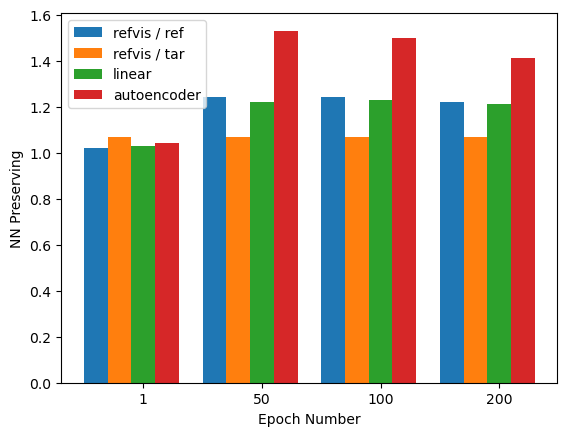

In [9]:
import numpy as np
import matplotlib.pyplot as plt

size = 4
name_list = ["1","50","100","200"]
x = np.arange(size)
a = [1.02,1.24,1.24,1.22]
b = [1.03,1.22,1.23,1.21]
c = [1.04,1.53,1.50,1.41]
d = [1.02,1.02,1.02,1.04]

total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2
plt.xlabel('Epoch Number')
plt.ylabel('NN Preserving')
plt.bar(x, a,  width=width, label='refvis / ref')
plt.bar(x + width, d,  width=width, label='refvis / tar')
plt.bar(x + 2 * width, b, width=width, label='linear',tick_label=name_list)
plt.bar(x + 3 * width, c, width=width, label='autoencoder')
plt.legend()
plt.show()


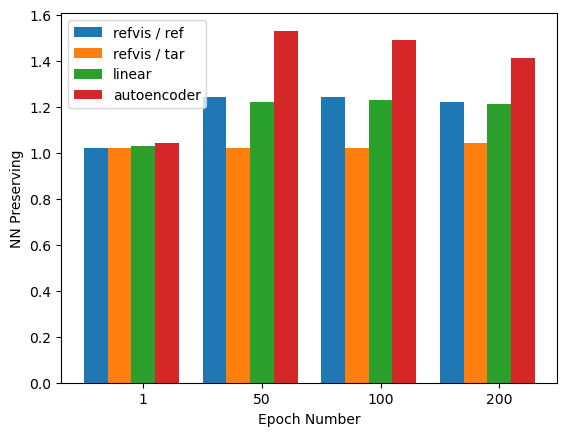

In [26]:
##### with predcition loss
import numpy as np
import matplotlib.pyplot as plt

size = 4
name_list = ["1","50","100","200"]
x = np.arange(size)
a = [1.02,1.24,1.24,1.22]
b = [1.03,1.22,1.23,1.21]
c = [1.04,1.53,1.49,1.41]
d = [1.02,1.02,1.02,1.04]

total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2
plt.xlabel('Epoch Number')
plt.ylabel('NN Preserving')
plt.bar(x, a,  width=width, label='refvis / ref')
plt.bar(x + width, d,  width=width, label='refvis / tar')
plt.bar(x + 2 * width, b, width=width, label='linear',tick_label=name_list)
plt.bar(x + 3 * width, c, width=width, label='autoencoder')
plt.legend()
plt.show()


In [98]:
##### eval
init_data = tar_provider.train_representation(TAR_EPOCH)
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 15

train_data = np.dot(init_data,R_n_2.detach().numpy())
embedding = projector.batch_project(REF_EPOCH, train_data)
linear_val = evaluate_proj_nn_perseverance_knn(init_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving: {:.2f}/{:d} in epoch {:d}".format(linear_val, n_neighbors, TAR_EPOCH))


Sat Apr  8 22:30:24 2023 Building RP forest with 16 trees
Sat Apr  8 22:30:25 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr  8 22:30:26 2023 Building RP forest with 16 trees
Sat Apr  8 22:30:26 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.22/15 in epoch 50


In [41]:

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = autoencoder.decoder(torch.Tensor(inv_data))
new_inv = new_inv.detach().numpy()
####### target prediction
pred = tar_provider.get_pred(TAR_EPOCH, tar_provider.train_representation(TAR_EPOCH)).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# autoencoder PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 8161.97it/s]

#train# autoencoder PPR: 0.94 in epoch 200


In [81]:
REF_EPOCH = 50
TAR_EPOCH = 50
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=1000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 80207328.0 loss2 {tensor(0.6497, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8440, requires_grad=True)}
batch_idx 199,iteration 199, loss1 1094.748046875 loss2 {tensor(0.7445, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7130, requires_grad=True)}
batch_idx 398,iteration 398, loss1 390.6304626464844 loss2 {tensor(0.5552, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6330, requires_grad=True)}
batch_idx 97,iteration 597, loss1 317.4765625 loss2 {tensor(0.5515, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6090, requires_grad=True)}
batch_idx 296,iteration 796, loss1 328.29412841796875 loss2 {tensor(0.5411, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6330, requires_grad=True)}
batch_idx 495,iteration 995, loss1 311.1195983886719 loss2 {tensor(0.4333, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6080, requires_grad=True)}


In [82]:

X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(REF_EPOCH))
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
S_n = alignment_n.align_embeddings_batch(X,Y,train_steps=1000,CKA_LAMBDA=100,CKA_LAMBAD_FOR_INIT=1e-3,N_LAMBDA=100)

batch_idx 0,iteration 0, loss1 98238056.0 loss2 {tensor(0.6130, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8200, requires_grad=True)}
batch_idx 199,iteration 199, loss1 1491.0352783203125 loss2 {tensor(0.8029, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7100, requires_grad=True)}
batch_idx 398,iteration 398, loss1 586.6943969726562 loss2 {tensor(0.6765, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6500, requires_grad=True)}
batch_idx 97,iteration 597, loss1 299.1494445800781 loss2 {tensor(0.5408, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5730, requires_grad=True)}
batch_idx 296,iteration 796, loss1 209.17984008789062 loss2 {tensor(0.4197, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5460, requires_grad=True)}
batch_idx 495,iteration 995, loss1 188.90074157714844 loss2 {tensor(0.3430, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5240, requires_grad=True)}


In [83]:
############# linear transfimrtaion PPR
train_data = np.dot(tar_provider.train_representation(REF_EPOCH), R_n_2.detach().numpy())
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = np.dot(inv_data, S_n.detach().numpy())
# new_inv = new_inv.detach().numpy()
pred = tar_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# linear PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 8100.68it/s]

#train# linear PPR: 0.14 in epoch 50


In [61]:
REF_EPOCH = 200
TAR_EPOCH = 200
train_data = ref_provider.train_representation(REF_EPOCH)
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)

pred = ref_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = ref_provider.get_pred(REF_EPOCH, inv_data).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# PPR ref vis + ref: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 8159.68it/s]

#train# PPR ref vis + ref: 0.93 in epoch 200


In [72]:
REF_EPOCH = 10
TAR_EPOCH = 10
train_data = tar_provider.train_representation(REF_EPOCH)
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)

pred = ref_provider.get_pred(REF_EPOCH, train_data).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, inv_data).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# PPR ref vis + tar: {:.2f} in epoch {:d}".format(val, REF_EPOCH))
 

100%|██████████| 250/250 [00:00<00:00, 6497.84it/s]

#train# PPR ref vis + tar: 0.50 in epoch 10


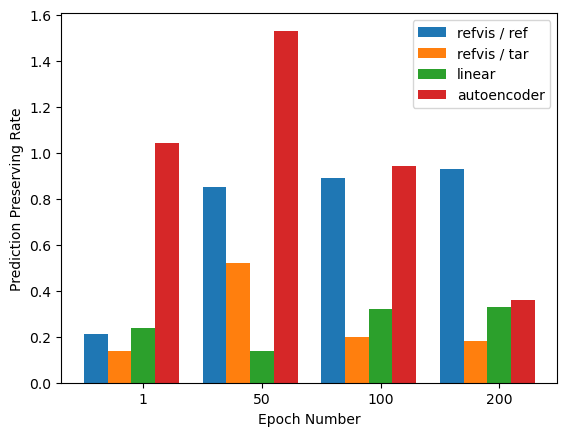

In [84]:
import numpy as np
import matplotlib.pyplot as plt

size = 4
name_list = ["1","50","100","200"]
x = np.arange(size)
#### timevis
a = [0.21,0.85,0.89,0.93]
#### tar in ref
d = [0.14,0.52,0.20,0.18]
#### linear
b = [0.24,0.14,0.32,0.33]
##### autoencoder
c = [1.04,1.53,0.94,0.36]


total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2
plt.xlabel('Epoch Number')
plt.ylabel('Prediction Preserving Rate')
plt.bar(x, a,  width=width, label='refvis / ref')
plt.bar(x + width, d,  width=width, label='refvis / tar')
plt.bar(x + 2 * width, b, width=width, label='linear',tick_label=name_list)
plt.bar(x + 3 * width, c, width=width, label='autoencoder')
plt.legend()
plt.show()

In [17]:
##### eval

import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

from singleVis.eval.evaluate import *
n_neighbors = 30

train_data = ref_train_data
embedding = projector.batch_project(REF_EPOCH, train_data)
val = evaluate_proj_nn_perseverance_knn(train_data, embedding, n_neighbors=n_neighbors, metric="euclidean")

print("#train# nn preserving: {:.2f}/{:d} in epoch {:d}".format(val, n_neighbors, epoch))


Sat Apr  8 00:50:00 2023 Building RP forest with 16 trees
Sat Apr  8 00:50:01 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr  8 00:50:04 2023 Building RP forest with 16 trees
Sat Apr  8 00:50:04 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.81/30 in epoch 99


Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 4888.49it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

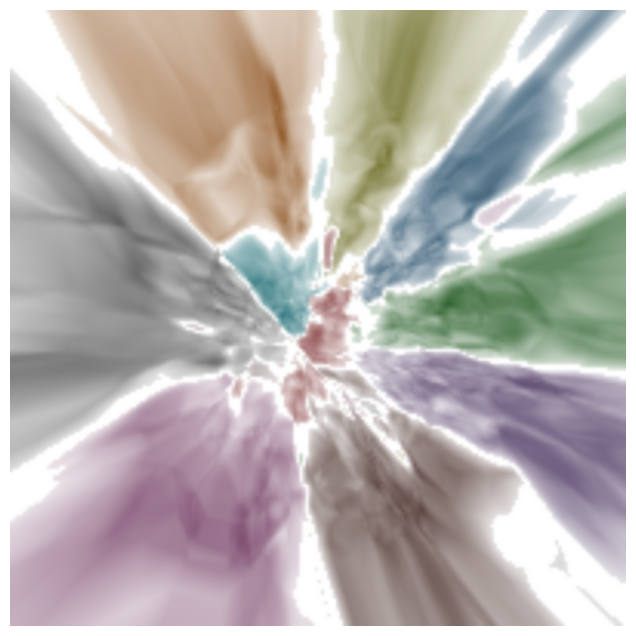

In [17]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [62]:
REF_EPOCH =1

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8070.94it/s]


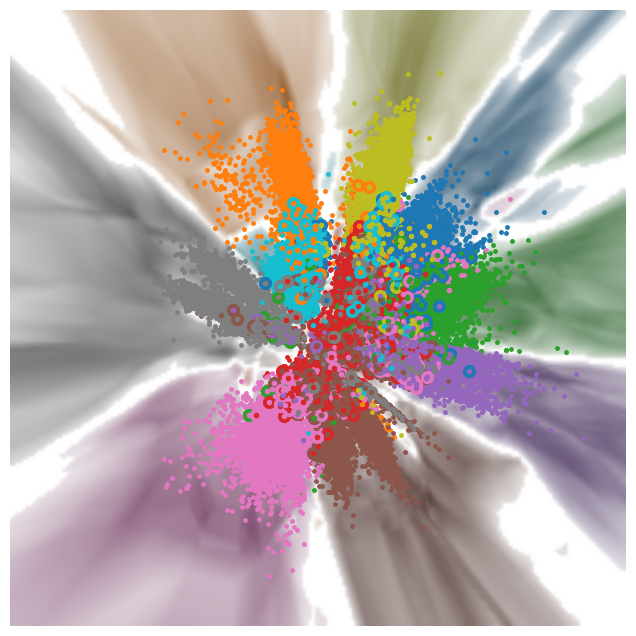

In [24]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.trans_visualizer import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider, I,I, ref_provider.train_representation(REF_EPOCH), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7930.30it/s]


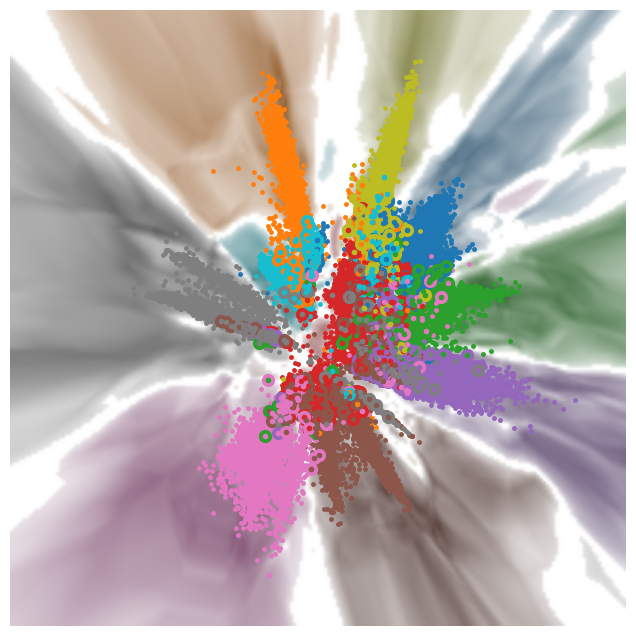

In [23]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [71]:
REF_EPOCH

1

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8461.79it/s]


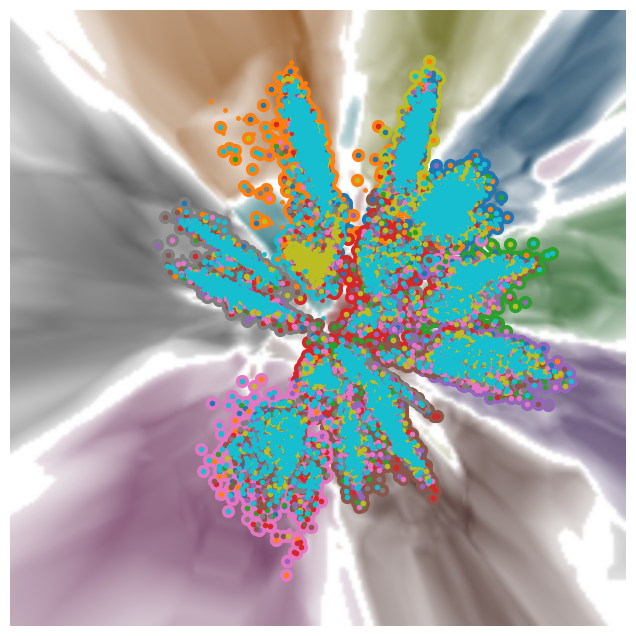

In [70]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5441.52it/s]


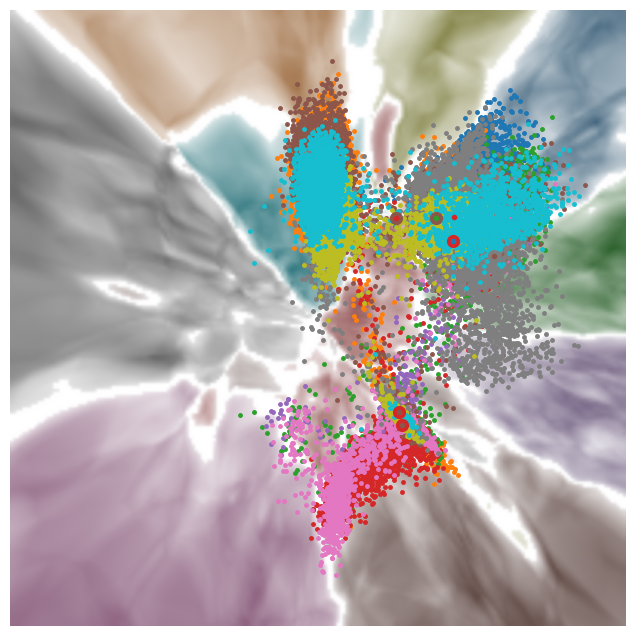

In [87]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data, I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))